# GA Performance

Checking the performance of our GA system can be done as we would do with any other optimization application thanks to the fact that we would usually export the algorithm's evolution to a `CSV` file. To show this in action we will make use of one of the examples from our [preprint](https://www.biorxiv.org/content/10.1101/2023.06.26.546301v1). We will take the results from the optimization of the São Tomé landscape and plot the GA evolution over generations.

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
from glob import glob
import numpy as np
import pandas as pd
from os import path
import MGSurvE as srv
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('comparison', './out/')
srv.makeFolder(OUT_PTH)

First, we will setup our paths and filename-related variables so that we can load the files easily. We ran the experiment for 10 repetitions with 5, 10, 15, and 20 traps; which are part of the filename differentiators:

In [2]:
# Experiment ID and statistic used --------------------------------------------
(ID, ST) = ('STPD', 'man')
TRP_NUM = ['05', '10', '15', '20']
# Setup paths and filename pattern --------------------------------------------
(PTH_DTA, FHEAD) = ('../../data/', f'{ID}-{ST}')
FP_PTRN = path.join(PTH_DTA, FHEAD+'_{}*.csv')
LD_PTRN = FHEAD+'_{}-{:02d}_TRP'

We will now create two dictionaries:
* `FNAMES`: stores the repetition filenames in order (value), for each one of the traps numbers (key)
* `GA_MIN`: contains the GA evolution array (value) where each row is a repetition of the optimization, for each one of the traps numbers (key)

In [3]:
FNAMES = {trp: sorted(glob(FP_PTRN.format(trp))) for trp in TRP_NUM}
GA_MIN = {
    trp: np.array([
        pd.read_csv(rep)['min'].values 
        for rep in FNAMES[trp]
    ]) for trp in TRP_NUM
}

Once we have them at hand, we can plot the GA evolution as we would do any other plot with [matplotlib](https://matplotlib.org/):

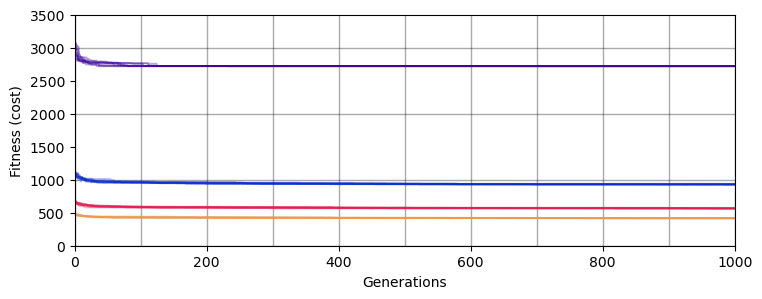

In [4]:
(XRAN, YRAN) = ((0, 1000), (0, 3500))
(COLS, ALPHA) = (['#390099', '#072ac8', '#e01a4f', '#ee964b'], '55')
(fig, ax) = plt.subplots(figsize=(35, 3))
for (ix, trp) in enumerate(TRP_NUM):
    ax.plot(GA_MIN[trp].T, color=COLS[ix]+ALPHA, lw=1.25)
ax.set_aspect(1/10)
ax.set_xlim(0, XRAN[1])
ax.set_ylim(YRAN[0], YRAN[1])
ax.set_xlabel('Generations')
ax.set_ylabel('Fitness (cost)')
ax.vlines(np.arange(XRAN[0], XRAN[1]+20, 100),  YRAN[0], YRAN[1], color='#00000055', lw=1, zorder=-10)
ax.hlines(np.arange(YRAN[0], YRAN[1]+25, 1000), XRAN[0], XRAN[1], color='#00000055', lw=1, zorder=-10)

From this point it's fairly simple to select the best repetition from each of our settings. We generate another dictionary which will hold a tuple of the index of the repetition along with the fitness value of the best iteration:

In [5]:
bestReps = {}
for trp in TRP_NUM:
    minreps = [min(rep) for rep in GA_MIN[trp]]
    minval = min(minreps)
    minix = minreps.index(minval)
    bestReps[trp] = (minix+1, minval)
bestReps

{'05': (1, 2718.59172418514),
 '10': (3, 925.5308607739668),
 '15': (8, 557.6682195067987),
 '20': (8, 405.7616430769117)}

Let's load the best landscape for each one of the trap scenarios into a dictionary as we have done before:

In [6]:
lnds = {
    trp: srv.loadLandscape(
        PTH_DTA, LD_PTRN.format(trp, bestReps[trp][0]), 
        fExt='pkl'
    ) for trp in TRP_NUM
}
lnds


{'05': <MGSurvE.landscape.Landscape at 0x29be2c250>,
 '10': <MGSurvE.landscape.Landscape at 0x1058f6c80>,
 '15': <MGSurvE.landscape.Landscape at 0x1058f70a0>,
 '20': <MGSurvE.landscape.Landscape at 0x10591a0e0>}

We can plot the map in a couple of simple commands as we have done for all of our examples to this point!

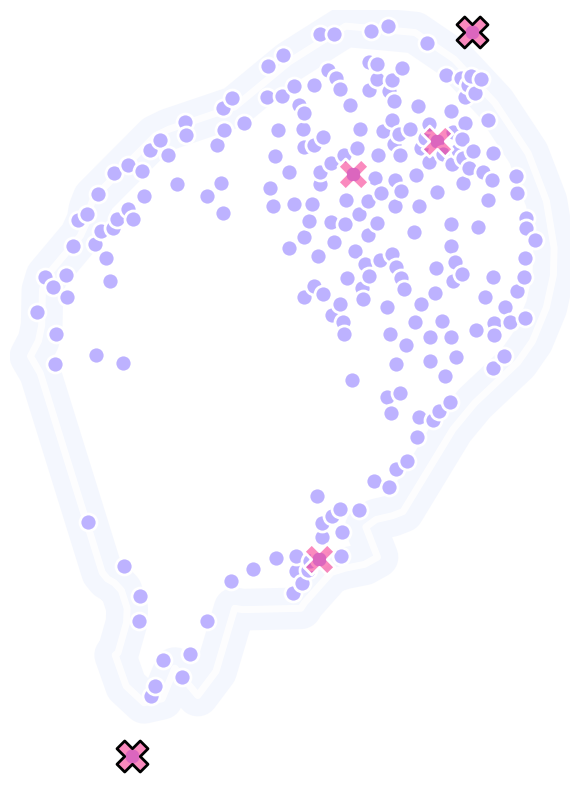

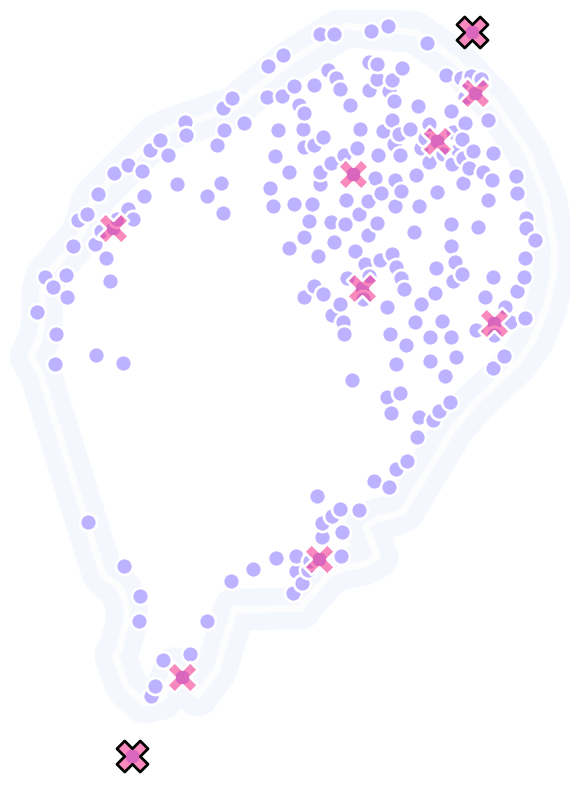

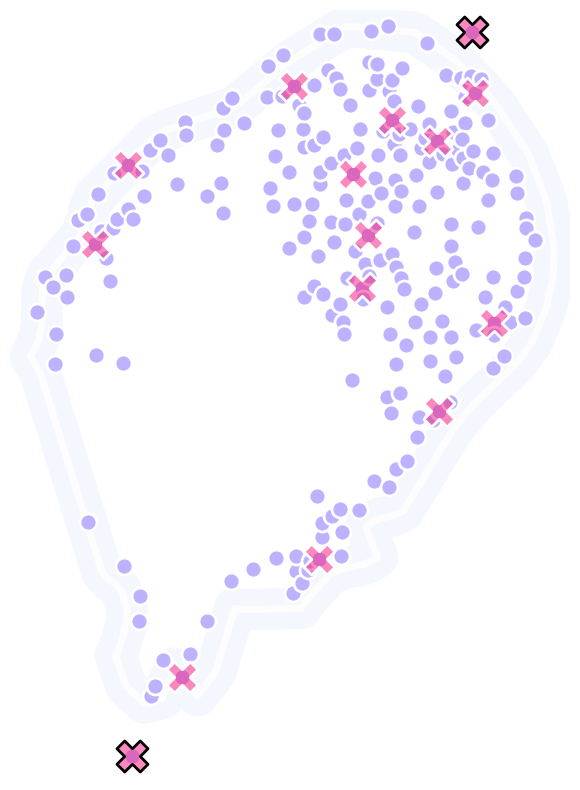

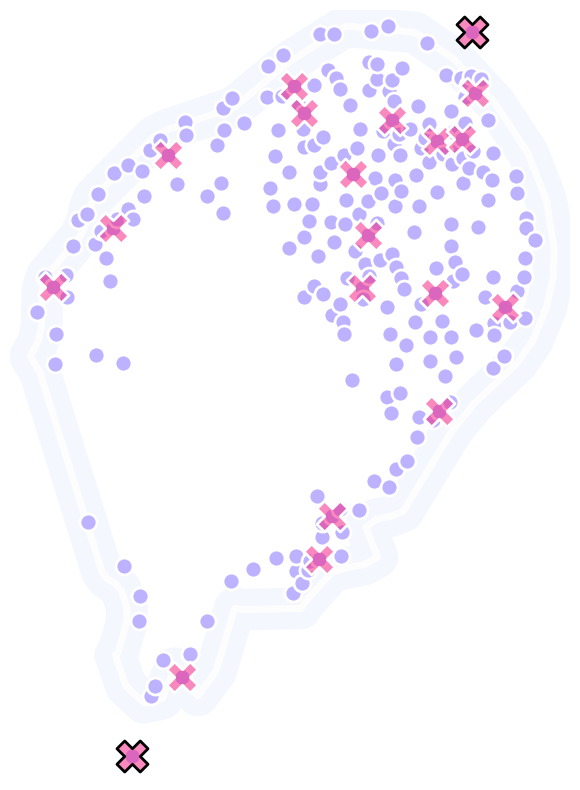

In [7]:
for trp in TRP_NUM:
    lnd = lnds[trp]
    (fig, ax) = (
        plt.figure(figsize=(10, 10)),
        plt.axes(projection=ccrs.PlateCarree())
    )
    lnd.plotSites(fig, ax, size=150)
    lnd.plotLandBoundary(fig, ax)
    lnd.plotTraps(
        fig, ax, size=500,
        zorders=(30, 25), transparencyHex='88', 
        proj=ccrs.PlateCarree()
    )
    srv.plotClean(fig, ax, bbox=((6.45, 6.77), (-0.02, 0.42)))
    fig.savefig(
        path.join(OUT_PTH, 'STP-{}.png'.format(trp)), 
        facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
    )